In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [2]:
prox_df = pd.read_json('data/out_0_600.json')
prox_df['label'] = 'unknown'
df = pd.concat([pd.read_json('data/out_neg_0_100.json'), pd.read_json('data/out_neg_0_50.json')], ignore_index=True)
df['label'] = 'neg'
df = df[~df.efoName.isin(['multiple sclerosis', 'inflammatory bowel disease', 'psoriasis', 'type 1 diabetes mellitus'])] #remove suspicious negatives
prox_df = pd.concat([prox_df, df], ignore_index=False)

In [20]:
df.efoName.unique()

array(['celiac disease', 'chronic obstructive pulmonary disease',
       "crohn's disease", 'rheumatoid arthritis',
       'systemic lupus erythematosus', 'asthma'], dtype=object)

In [3]:
potential_areas = [k for k,v in prox_df[(prox_df.label == 'unknown') & (prox_df.z_score < -1)].groupby('efoName')['chemName'].size().to_dict().items() if v >= 3]

In [4]:
prox_df[(prox_df.label == 'unknown') & (prox_df.z_score < -1) & (prox_df.efoName.isin(potential_areas))].groupby('chemName')['efoName'].apply(set).to_dict()

{'Ascorbic acid': {'mitral valve prolapse',
  'myocardial ischemia',
  'vein disorder'},
 'Citric acid': {'dilated cardiomyopathy',
  'familial dilated cardiomyopathy',
  'familial progressive cardiac conduction defect',
  'hypertrophic cardiomyopathy',
  'moyamoya disease',
  'phlebitis',
  'ventricular fibrillation',
  'ventricular tachycardia'},
 'Corilagin': {'vein disorder'},
 'Ellagic acid': {'essential hypertension',
  'familial dilated cardiomyopathy',
  'familial isolated arrhythmogenic right ventricular dysplasia',
  'familial progressive cardiac conduction defect',
  'hypertrophic cardiomyopathy',
  'mitral valve prolapse',
  'moyamoya disease',
  'myocardial ischemia',
  'phlebitis',
  'sudden cardiac arrest',
  'ventricular fibrillation',
  'ventricular tachycardia'},
 'Gallic acid': {'dilated cardiomyopathy',
  'familial dilated cardiomyopathy',
  'familial isolated arrhythmogenic right ventricular dysplasia',
  'hypertrophic cardiomyopathy'},
 'Kaempferol': {'essential h

In [5]:
cvd_cluster = pd.read_csv('data/cvd_cluster.csv')

In [6]:
def f(x):
    if x == 52: 
        return('#ac5baa')
    elif x == 14:
        return('#4c8bc6')
    else:
        return('#c1b9eb')
cvd_cluster['color'] = cvd_cluster.cluster_idx.apply(f)

In [7]:
prox_df['adj_pvalue'] = prox_df.groupby('chemName')['pvalue'].apply(list).apply(lambda x:
 multipletests(x, method='fdr_bh')[1]).reset_index().explode('pvalue').pvalue.tolist()

In [8]:
#prox_df['star'] = prox_df.pvalue.apply(lambda x: '*' if x<=0.05 else '')
#prox_df['star'] = prox_df.adj_pvalue.apply(lambda x: '*' if x<=0.05 else '')
prox_df['star'] = prox_df.z_score.apply(lambda x: '*' if x<-1 else '')

In [9]:
prox_df = prox_df.merge(cvd_cluster[['cvd', 'cluster_idx']].rename(columns={'cvd':'efoName'}), on='efoName', how='left')

In [10]:
c = cvd_cluster.cluster_idx.unique().max() + 1
prox_df['cluster_idx'] = prox_df.cluster_idx.apply(lambda x: c if pd.isna(x) else x)

In [11]:
prox_df = prox_df.sort_values('cluster_idx')

In [12]:
mtx = prox_df.pivot(index='efoName', columns=['chemName'], values='z_score')
txt = prox_df.pivot(index='efoName', columns=['chemName'], values='star') 

In [13]:
mtx = mtx.reindex(prox_df.efoName.unique())
txt = txt.reindex(prox_df.efoName.unique())

In [14]:
prox_df.chemName.unique()

array(['Ascorbic acid', 'Pedunculagin', 'Ellagic acid', 'Corilagin',
       'Pyrogallol', 'Kaempferol', 'Gallic acid', 'Citric acid',
       'Quercetin'], dtype=object)

In [26]:
prox_df[(prox_df.chemName.isin(['Quercetin', 'Kaempferol'])) & (prox_df.star == '*')].efoName.unique()

array(['atherosclerosis', 'hypertension, pregnancy-induced',
       'essential hypertension', 'myocardial ischemia',
       'peripheral vascular disease', 'hypertension',
       'diabetic retinopathy', 'moyamoya disease', 'cor pulmonale',
       'phlebitis', 'mitral valve prolapse', 'noonan syndrome',
       'pulmonary embolism', 'ventricular septal defect',
       'sudden cardiac arrest', 'ventricular fibrillation',
       'ventricular tachycardia', 'dilated cardiomyopathy',
       'familial dilated cardiomyopathy',
       'familial isolated arrhythmogenic right ventricular dysplasia',
       'brugada syndrome',
       'familial progressive cardiac conduction defect',
       'rheumatoid arthritis', "crohn's disease"], dtype=object)

In [15]:
col_colors = {
    'Ascorbic acid': '#008480',
    'Corilagin': '#eba628',
    'Ellagic acid': '#eba628',
    'Gallic acid': '#7644b5',
    'Kaempferol': '#007f36',
    'Pedunculagin': '#eba628',
    'Pyrogallol': '#77c600',
    'Quercetin': '#007f36',
    'Citric acid': '#0e679f'
}

In [16]:
row_colors = dict(zip(cvd_cluster.cvd, cvd_cluster.color))

In [17]:
for d in prox_df[prox_df.label == 'neg'].efoName.unique(): row_colors[d] = 'black'

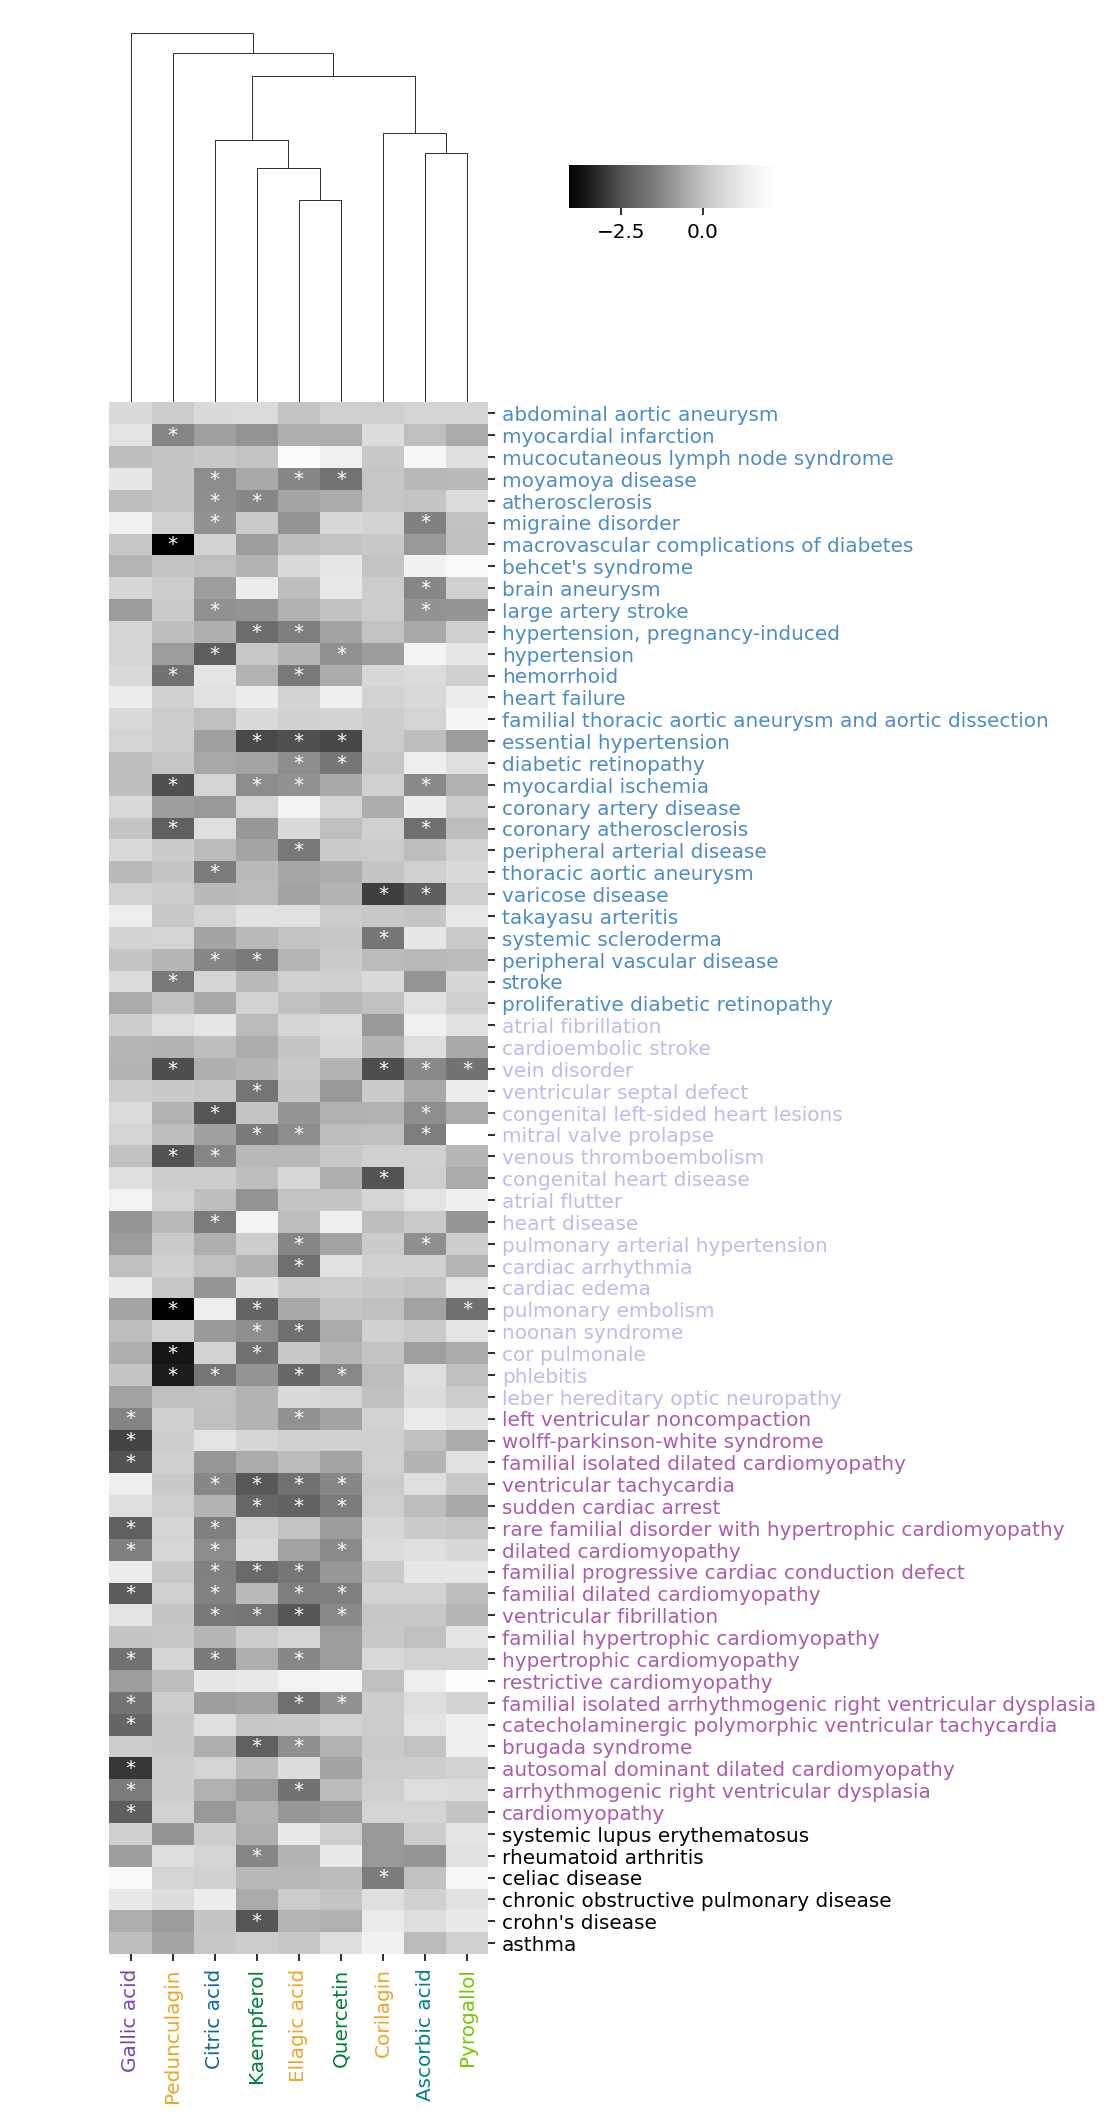

In [18]:
g = sns.clustermap(data=mtx, xticklabels=True, yticklabels=True, cbar_pos=(0.5, 0.9, 0.18, 0.02), row_cluster=False,
               cbar_kws={'orientation':'horizontal'}, figsize=(8, 15), cmap='Greys_r',
               annot=txt.values.tolist(), fmt='')#, cbar=False)
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

i = 0 
for chem in g.ax_heatmap.get_xticklabels():
    g.ax_heatmap.get_xticklabels()[i].set_color(col_colors[chem.get_text()])
    i += 1

i = 0 
for dis in g.ax_heatmap.get_yticklabels():
    g.ax_heatmap.get_yticklabels()[i].set_color(row_colors[dis.get_text()])
    i += 1

plt.savefig('figures/GB_proximity_to_CVDs.svg', bbox_inches='tight')

In [19]:
cvd_cluster.cluster_idx.value_counts()

14    28
52    19
45    18
Name: cluster_idx, dtype: int64

In [23]:
prox_df.chemName.unique()

array(['Ascorbic acid', 'Gallic acid', 'Pyrogallol', 'Ellagic acid',
       'Corilagin', 'Quercetin', 'Pedunculagin', 'Kaempferol',
       'Citric acid'], dtype=object)

In [24]:
prox_df[(prox_df.star == '*') & (prox_df.chemName == 'Citric acid')]

,chemName,efoName,d_c,z_score,mu,sigma,pvalue,label,adj_pvalue,star,cluster_idx
105,Citric acid,moyamoya disease,1.866667,-1.139988,1.978933,0.098481,0.195,unknown,0.955479,*,14.0
111,Citric acid,peripheral vascular disease,2.000000,-1.272742,2.143533,0.112775,0.160,unknown,0.925000,*,14.0
122,Citric acid,thoracic aortic aneurysm,1.866667,-1.517254,2.010200,0.094601,0.108,unknown,0.820000,*,14.0
103,Citric acid,migraine disorder,1.666667,-1.007878,1.762200,0.094787,0.230,unknown,0.820000,*,14.0
67,Citric acid,atherosclerosis,1.866667,-1.123995,1.990667,0.110321,0.190,unknown,0.982000,*,14.0
96,Citric acid,hypertension,1.200000,-2.224820,1.482467,0.126962,0.031,unknown,0.820000,*,14.0
99,Citric acid,large artery stroke,1.800000,-1.054137,1.905000,0.099608,0.211,unknown,0.820000,*,14.0
125,Citric acid,venous thromboembolism,1.666667,-1.296133,1.790600,0.095618,0.154,unknown,0.960000,*,45.0
112,Citric acid,phlebitis,1.933333,-1.691274,2.127133,0.114588,0.075,unknown,0.955479,*,45.0
93,Citric acid,heart disease,1.933333,-1.534639,2.106933,0.113121,0.101,unknown,0.955479,*,45.0


1. Chemicals in Gooseberry demonstrate complementary proximity profiles to CVDs.
2. Most of the chemicals in Gooseberry are predicted to have an effect (no comment on directionality) on a group of CVDs. 
3. Senolytics (Ellagic acid and Quercetin) have similar proximity profiles. They are proximal to more extensive CVDs than senomorphics (Kaemferol).

### chemical-gene sets v1 vs v2 

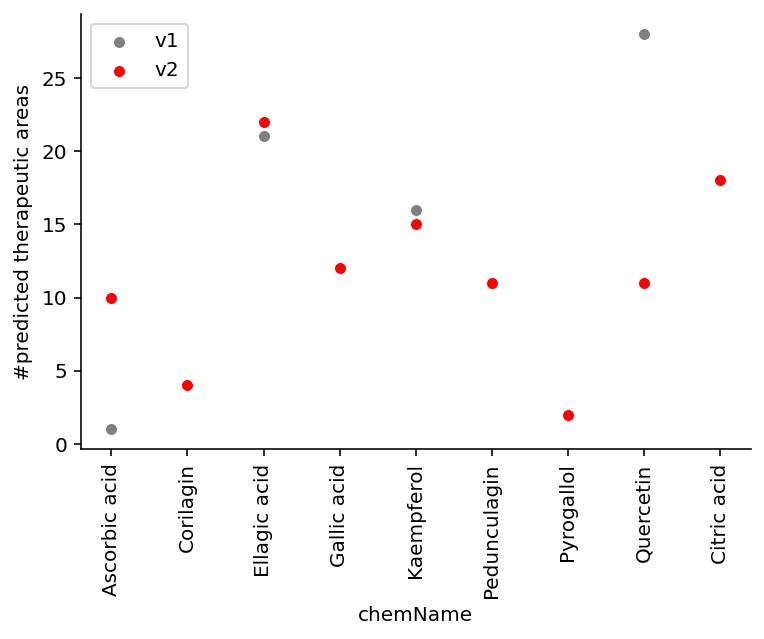

In [25]:
v1 = pd.read_json('data/out_0_600_v1.json')
v1 = v1[v1.z_score < -1].groupby('chemName')['efoName'].size().reset_index()

v2 = pd.read_json('data/out_0_600.json')
v2 = v2[v2.z_score < -1].groupby('chemName')['efoName'].size().reset_index()

sns.scatterplot(data=v1, x='chemName', y='efoName', color='grey')
sns.scatterplot(data=v2, x='chemName', y='efoName', color='red')
plt.xticks(rotation=90)
plt.ylabel('#predicted therapeutic areas')
plt.legend(['v1', 'v2'])
sns.despine()